# THESIS FILE - Annicchiarico

In this notenook I will go over the steps that I took to elaborate the data and obtain the results necessary to complete my thesis. 

The goal of my work is to investigate the efficiency of using supervised machine learning classification tools to aid market authorities in the screening of large amount of data to detect suspicious activity that might be correlated to price collusive agreements. 

* RQ1: Can machine learning algorithms be an efficient tool in analysing price data in order to screen for collusive behaviour in the market?
* RQ2: Which price measures can be the most useful in predicting collusion?

More specifically, my research will be focused on the market of gasoline retailers in Italy. A market characterized by prices that are susceptible to large and frequent changes and to a large number of operators, thus making a market-wide econometric estimation less feasible, while at the same time being a perfect environment in which to test the usefulness of ML algorithms.

The rest of this document will be divided in two parts. The first will be dedicated to the creation of the necessary market measures, while in the second I will train and run three ML algorithms to obtain the result. I will not give here an-in depth analysis of the results as it will be done in the thesis.

## PART I - Market Measures

In this section I will go from the original dataframes, extracted from national statistics website, to the final dataframes that will be used by the algorithms. This means cleaning the uneccessary data, reshape the file into a time-series sequence, separate the two observed produts (gasoline and diesel), create weekly time groups, calculate the three statistical  moments measures of prices.

### Set Up

In [1]:
import pandas as pd
import os
import numpy as np
from scipy.stats import skew

livigno = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\livigno_data.csv")

sondrio = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\sondrio_data.csv")

livigno.head()

C:\Users\loren\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,idImpianto,Nome,descCarburante,Comune,1/1/2015,1/2/2015,1/3/2015,1/4/2015,1/5/2015,1/6/2015,...,3/22/2024,3/23/2024,3/24/2024,3/25/2024,3/26/2024,3/27/2024,3/28/2024,3/29/2024,3/30/2024,3/31/2024
0,21866,BONDI CARBURANTI DI BORMOLINI LUIGI S.R.L.,Benzina,Livigno,0.711,0.711,0.704,0.704,0.704,0.704,...,1.141,1.156,1.156,1.156,1.156,1.156,1.156,1.156,1.171,1.171
1,21869,BONDI CARBURANTI DI BORMOLINI LUIGI S.R.L.,Benzina,Livigno,0.711,0.711,0.704,0.704,0.704,0.704,...,1.141,1.156,1.156,1.156,1.156,1.156,1.156,1.156,1.171,1.171
2,51253,C-ENERGIA S.R.L.,Benzina,Livigno,NaN,NaN,NaN,NaN,NaN,NaN,...,1.142,1.142,1.156,1.156,1.156,1.156,1.156,1.156,1.156,1.173
3,22670,CU.BA. S.R.L.,Benzina,Livigno,0.710,0.710,0.703,0.703,0.703,0.703,...,1.141,1.141,1.157,1.157,1.157,1.157,1.157,1.157,1.157,1.174
4,22320,CUS. CAR. S.R.L,Benzina,Livigno,0.710,0.710,0.703,0.703,0.703,0.703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
sondrio.head()

,idImpianto,Nome,descCarburante,Comune,isSelf,1/1/2015,1/2/2015,1/3/2015,1/4/2015,1/5/2015,...,3/22/2024,3/23/2024,3/24/2024,3/25/2024,3/26/2024,3/27/2024,3/28/2024,3/29/2024,3/30/2024,3/31/2024
0,7209,F.LLI ROMERI S.N.C.,Benzina,Sondrio,1,0.514282,0.516682,0.516682,0.516682,0.516682,...,0.811764,0.811764,0.811764,0.811764,0.811764,0.811764,0.811764,0.811764,0.811764,0.811764
1,14349,CAVALLI BRUNO,Benzina,Sondrio,1,0.505266,0.507666,0.507666,0.507666,0.507666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18789,FANCHETTI FABIO,Benzina,Sondrio,1,0.547069,0.549469,0.549469,0.549469,0.549469,...,0.828157,0.828157,0.828157,0.828157,0.828157,0.828157,0.819961,0.819961,0.819961,0.819961
3,38847,CIOCCARELLI CLAUDIO E FIGLI S.N.C.,Benzina,Sondrio,1,NaN,NaN,NaN,NaN,NaN,...,0.811764,0.811764,0.811764,0.811764,0.819961,0.819961,0.819961,0.819961,0.819961,0.819961
4,47199,ESSO,Benzina,Sondrio,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again, the starting points are two different dataframes, one for the city of Livigno known to have been characterized by collusion, and one for the city of Sondrio, the competitice "counterfactual". Both files are structured similarly, the first 5 columns give informations on the recorded retailer, as below, while the remaining columns stand for the recording of the prices for that specific day, from the 01-01-2015 to 25-03-2024.

Columns:
* *idImpianto*: number associated with physical retail store
* *Nome*: name of store
* *descCarburante*: type of product for which the price is recorded
* *Comune*: city where the retailer is located
* *isSelf*: type of service at store, 1 mean self-service (0 is not present as it was removed at the source)

As it will be mentioned in the final thesis these prices are calculated before taxes, due to the difference in fiscal statute of the two cities.

### Data Cleaning

Each dataframe is split into two dataframes based on the the product data (gasoline and diesel), then it is cleaned of the irrelevant information such as the unique id or the name of the product, finally it is trasposed such that the first column contains all the dates and the following columns stand for each retailer. 

Because we will work with weeks I also choose to drop the first 4 days in order to start and end my df on a Monday-Sunday weekly period.

In [3]:
# LIVIGNO (cartel)
# Separate into Gasoline and Gasolio
livigno_gasoline = livigno[livigno['descCarburante'] == 'Benzina']
livigno_diesel = livigno[livigno['descCarburante'] != 'Benzina']

# Drop unnecessary columns
livigno_gasoline = livigno_gasoline.drop(columns=["descCarburante", "idImpianto", "Comune"])
livigno_diesel = livigno_diesel.drop(columns=["descCarburante", "idImpianto", "Comune"])

# Transpose and set index as 'Date'
livigno_gasoline = livigno_gasoline.T
livigno_gasoline.columns = livigno_gasoline.iloc[0]
livigno_gasoline = livigno_gasoline[1:]
livigno_gasoline.index.name = 'Date'

livigno_diesel = livigno_diesel.T
livigno_diesel.columns = livigno_diesel.iloc[0]
livigno_diesel = livigno_diesel[1:]
livigno_diesel.index.name = 'Date'

# SONDRIO (competitive)
sondrio_gasoline = sondrio.loc[sondrio['descCarburante'] == 'Benzina']
sondrio_diesel = sondrio.loc[sondrio['descCarburante'] != 'Benzina']

sondrio_gasoline = sondrio_gasoline.drop(columns = ["descCarburante", "idImpianto", "Comune", "isSelf"])
sondrio_diesel = sondrio_diesel.drop(columns = ["descCarburante", "idImpianto", "Comune", "isSelf"])

# Transpose and set index as 'Date'
sondrio_gasoline = sondrio_gasoline.T
sondrio_gasoline.columns = sondrio_gasoline.iloc[0]
sondrio_gasoline = sondrio_gasoline[1:]
sondrio_gasoline.index.name = 'Date'

sondrio_diesel = sondrio_diesel.T
sondrio_diesel.columns = sondrio_diesel.iloc[0]
sondrio_diesel = sondrio_diesel[1:]
sondrio_diesel.index.name = 'Date'

# Delete first 4 days
livigno_gasoline=livigno_gasoline.drop(["1/1/2015", "1/2/2015", "1/3/2015", "1/4/2015"], axis = 0)
livigno_diesel=livigno_diesel.drop(["1/1/2015", "1/2/2015", "1/3/2015", "1/4/2015"], axis = 0)

sondrio_gasoline=sondrio_gasoline.drop(["1/1/2015", "1/2/2015", "1/3/2015", "1/4/2015"], axis = 0)
sondrio_diesel=sondrio_diesel.drop(["1/1/2015", "1/2/2015", "1/3/2015", "1/4/2015"], axis = 0)

#SAVE
livigno_gasoline.to_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\livigno_gasoline_T.csv", index=True)
livigno_diesel.to_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\livigno_diesel_T.csv", index=True)

sondrio_gasoline.to_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\sondrio_gasoline_T.csv", index=True)
sondrio_diesel.to_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\sondrio_diesel_T.csv", index=True)

### Coefficient of Variation

The first collusion measure is the coefficient of variation (CV) calculated for each municipality and product as follows:

$$
CV = \frac{\sigma}{\bar{x}}
$$

Hence the ratio between the std deviation ($\sigma$) and the mean of the prices ($\bar{x}$). This measure is calculated per day, but in order to study the market over time weekly groups are created with means.

*I had to save and reload the files as for some unknown reason the index from the transposition gets lost.*


In [4]:
livigno_gasoline = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\livigno_gasoline_T.csv", index_col='Date')
livigno_diesel = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\livigno_diesel_T.csv", index_col='Date')
sondrio_gasoline = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\sondrio_gasoline_T.csv", index_col='Date')
sondrio_diesel = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\sondrio_diesel_T.csv", index_col='Date')

livigno_gasoline.index = pd.to_datetime(livigno_gasoline.index)
livigno_diesel.index = pd.to_datetime(livigno_diesel.index)
sondrio_gasoline.index = pd.to_datetime(sondrio_gasoline.index)
sondrio_diesel.index = pd.to_datetime(sondrio_diesel.index)

# LIVIGNO (collusive)
    #Petrol
livigno_gasoline['PriceMean'] = livigno_gasoline.mean(axis =1)
livigno_gasoline['StdDeviation'] = livigno_gasoline.std(axis=1)
livigno_gasoline['CV'] = livigno_gasoline['StdDeviation']/livigno_gasoline['PriceMean']

livigno_gasoline = livigno_gasoline.groupby(pd.Grouper(level='Date', freq='W-MON')).mean()

    #Diesel
livigno_diesel['PriceMean'] = livigno_diesel.mean(axis =1)
livigno_diesel['StdDeviation'] = livigno_diesel.std(axis=1)
livigno_diesel['CV'] = livigno_diesel['StdDeviation']/livigno_diesel['PriceMean']

livigno_diesel = livigno_diesel.groupby(pd.Grouper(level='Date', freq='W-MON')).mean()



# SONDRIO (competitive)
    #Petrol
sondrio_gasoline['PriceMean'] = sondrio_gasoline.mean(axis =1)
sondrio_gasoline['StdDeviation'] = sondrio_gasoline.std(axis=1)
sondrio_gasoline['CV'] = sondrio_gasoline['StdDeviation']/sondrio_gasoline['PriceMean']

sondrio_gasoline = sondrio_gasoline.groupby(pd.Grouper(level='Date', freq='W-MON')).mean()

    #Diesel
sondrio_diesel['PriceMean'] = sondrio_diesel.mean(axis =1)
sondrio_diesel['StdDeviation'] = sondrio_diesel.std(axis=1)
sondrio_diesel['CV'] = sondrio_diesel['StdDeviation']/sondrio_diesel['PriceMean']

sondrio_diesel = sondrio_diesel.groupby(pd.Grouper(level='Date', freq='W-MON')).mean()

sondrio_diesel.head()

,F.LLI ROMERI S.N.C.,CAVALLI BRUNO,FANCHETTI FABIO,CIOCCARELLI CLAUDIO E FIGLI S.N.C.,ESSO,FORTINI STEFANO,EGI-2GO S.R.L.,CENTELLEGHE LUCA,FUEL SERVICE S.A.S.,PriceMean,StdDeviation,CV
Date,,,,,,,,,,,,
2015-01-05,0.578502,0.563748,0.594895,NaN,NaN,NaN,NaN,NaN,NaN,0.579048,0.012722,0.021970
2015-01-12,0.578502,0.538689,0.594895,NaN,NaN,NaN,NaN,NaN,NaN,0.570695,0.023687,0.041622
2015-01-19,0.591616,0.509649,0.576862,NaN,NaN,NaN,NaN,NaN,NaN,0.559376,0.039323,0.070443
2015-01-26,0.589626,0.503326,0.504731,NaN,NaN,NaN,NaN,NaN,NaN,0.532561,0.040422,0.075896
2015-02-02,0.526394,0.512108,0.504731,NaN,NaN,NaN,NaN,NaN,NaN,0.514411,0.009345,0.017875


### High Means

The second measure is high means (HM), simply computed as the difference between the national mean ($\bar{Y}$) of prices and the mean of the price in the region of interest ($\bar{Y}$), again over weekly periods. 
$$
HM = \bar{Y} - \bar{x}
$$
For this I first need to load a separate dataset that contains said national statistics, available from ministry sources already calulated pre-tax.

In [5]:
nat_data = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\prezzi_medi.csv", index_col='DATA_RILEVAZIONE')
nat_data.index = pd.to_datetime(nat_data.index)

mean_gasoline = nat_data["Benzina"]
mean_diesel = nat_data["Gasolio"]

## For Petrol
livigno_gasoline = pd.concat([livigno_gasoline, mean_gasoline.rename("NatMean")], axis = 1)
livigno_gasoline['HM'] = livigno_gasoline['NatMean'] - livigno_gasoline['PriceMean']

sondrio_gasoline = pd.concat([sondrio_gasoline, mean_gasoline.rename("NatMean")], axis = 1)
sondrio_gasoline['HM'] = sondrio_gasoline['NatMean'] - sondrio_gasoline['PriceMean']

##For diesel
livigno_diesel = pd.concat([livigno_diesel, mean_diesel.rename("NatMean")], axis = 1)
livigno_diesel['HM'] = livigno_diesel['NatMean'] - livigno_diesel['PriceMean']

sondrio_diesel = pd.concat([sondrio_diesel, mean_diesel.rename("NatMean")], axis = 1)
sondrio_diesel['HM'] = sondrio_diesel['NatMean'] - sondrio_diesel['PriceMean']

livigno_gasoline.head()

,BONDI CARBURANTI DI BORMOLINI LUIGI S.R.L.,BONDI CARBURANTI DI BORMOLINI LUIGI S.R.L..1,C-ENERGIA S.R.L.,CU.BA. S.R.L.,CUS. CAR. S.R.L,FIBO S.R.L,G.M.F. S.R.L,GES.CAR. S.A.S. DI TRE.C S.R.L.,GLOBAL SERVICE S.R.L.,MARKET S. ANTON DI COMPAGNONI VIRGILIO & C. S.A.S.,SILROC S.R.L.,TRE.CAR. S.R.L.,PriceMean,StdDeviation,CV,NatMean,HM
2015-01-05,0.704000,0.704000,NaN,0.703000,0.703000,0.703000,NaN,0.703000,NaN,0.703000,NaN,0.703000,0.703250,0.000433,0.000616,0.50582,-0.197430
2015-01-12,0.692000,0.692000,NaN,0.691000,0.691000,0.691000,NaN,0.691000,NaN,0.691000,NaN,0.691000,0.691250,0.000433,0.000627,0.47883,-0.212420
2015-01-19,0.665200,0.665200,NaN,0.664200,0.664200,0.664200,NaN,0.664200,NaN,0.664200,NaN,0.664200,0.664450,0.000433,0.000652,0.45872,-0.205730
2015-01-26,0.658000,0.658000,NaN,0.657000,0.657000,0.657000,NaN,0.657000,NaN,0.657000,NaN,0.657000,0.657250,0.000433,0.000659,0.44950,-0.207750
2015-02-02,0.662286,0.662286,NaN,0.661286,0.661286,0.661286,NaN,0.661286,NaN,0.661286,NaN,0.661286,0.661536,0.000433,0.000655,0.45661,-0.204926


### Skewness of Price Changes

The third and last measure of collusion is the skewness of price changes. Literature shows that when the distribution of price changes in a time frame is skewed towards more increases than decreases it might signal colluissive behaviour. Skewness will be calculated with the `.skew()` package which uses the [Fisher-Pearson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) coefficient:
$$
g_1 = \frac{m_3}{m_2^\frac{3}{2}}
$$
where: $m_i = \frac{1}{N}\sum_{n=1}^{N}(x[n]-\bar{x})^i$

As such, for this measure firstly we need to find the the price changes for each retailer across each day. The price changes are then grouped per week, and the skewness is calculated within the distribution of those weekly groups. This is a longer process so the first chunk will be only for Livigno while the second for Sondrio, but the process is the same.

In [6]:
##LIVIGNO
# Reload daily prices
daily_livgno_gasoline = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\livigno_gasoline_T.csv", index_col='Date')
daily_livgno_gasoline.index = pd.to_datetime(daily_livgno_gasoline.index)

daily_livgno_diesel = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\livigno_diesel_T.csv", index_col='Date')
daily_livgno_diesel.index = pd.to_datetime(daily_livgno_diesel.index)

#Calculate Daily Changes
gasoline_changes = daily_livgno_gasoline.diff().fillna(0)
diesel_changes = daily_livgno_diesel.diff().fillna(0)

weekly_gasoline = [group for _, group in gasoline_changes.groupby(pd.Grouper(freq='W-SUN',origin='start'))]
weekly_diesel = [group for _, group in diesel_changes.groupby(pd.Grouper(freq='W-SUN',origin='start'))]

#Calculate Skewness
skewness_gasoline = []
for weekly_df in weekly_gasoline:
    skewness = weekly_df.stack().skew()  
    week_start = weekly_df.index[0].strftime('%m/%d/%Y') 
    skewness_gasoline.append({'Date': week_start, 'Skewness': skewness})
    
skewness_diesel = []
for weekly_df in weekly_diesel:
    skewness = weekly_df.stack().skew()  
    week_start = weekly_df.index[0].strftime('%m/%d/%Y') 
    skewness_diesel.append({'Date': week_start, 'Skewness': skewness})

#Create df
gasoline_skewness_df = pd.DataFrame(skewness_gasoline)
gasoline_skewness_df= gasoline_skewness_df.set_index("Date")
gasoline_skewness_df.index = pd.to_datetime(gasoline_skewness_df.index)
    
diesel_skewness_df = pd.DataFrame(skewness_diesel)
diesel_skewness_df= diesel_skewness_df.set_index("Date")
diesel_skewness_df.index = pd.to_datetime(diesel_skewness_df.index)


#Join on original df
livigno_gasoline = pd.concat([livigno_gasoline, gasoline_skewness_df], axis = 1)
livigno_diesel = pd.concat([livigno_diesel, diesel_skewness_df], axis = 1)

livigno_gasoline.head()

,BONDI CARBURANTI DI BORMOLINI LUIGI S.R.L.,BONDI CARBURANTI DI BORMOLINI LUIGI S.R.L..1,C-ENERGIA S.R.L.,CU.BA. S.R.L.,CUS. CAR. S.R.L,FIBO S.R.L,G.M.F. S.R.L,GES.CAR. S.A.S. DI TRE.C S.R.L.,GLOBAL SERVICE S.R.L.,MARKET S. ANTON DI COMPAGNONI VIRGILIO & C. S.A.S.,SILROC S.R.L.,TRE.CAR. S.R.L.,PriceMean,StdDeviation,CV,NatMean,HM,Skewness
2015-01-05,0.704000,0.704000,NaN,0.703000,0.703000,0.703000,NaN,0.703000,NaN,0.703000,NaN,0.703000,0.703250,0.000433,0.000616,0.50582,-0.197430,-2.808161
2015-01-12,0.692000,0.692000,NaN,0.691000,0.691000,0.691000,NaN,0.691000,NaN,0.691000,NaN,0.691000,0.691250,0.000433,0.000627,0.47883,-0.212420,-2.808161
2015-01-19,0.665200,0.665200,NaN,0.664200,0.664200,0.664200,NaN,0.664200,NaN,0.664200,NaN,0.664200,0.664450,0.000433,0.000652,0.45872,-0.205730,0.000000
2015-01-26,0.658000,0.658000,NaN,0.657000,0.657000,0.657000,NaN,0.657000,NaN,0.657000,NaN,0.657000,0.657250,0.000433,0.000659,0.44950,-0.207750,2.808161
2015-02-02,0.662286,0.662286,NaN,0.661286,0.661286,0.661286,NaN,0.661286,NaN,0.661286,NaN,0.661286,0.661536,0.000433,0.000655,0.45661,-0.204926,2.808161


In [7]:
##SONDRIO
# Reload daily prices
daily_sondrio_gasoline = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\sondrio_gasoline_T.csv", index_col='Date')
daily_sondrio_gasoline.index = pd.to_datetime(daily_sondrio_gasoline.index)

daily_sondrio_diesel = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\sondrio_diesel_T.csv", index_col='Date')
daily_sondrio_diesel.index = pd.to_datetime(daily_sondrio_diesel.index)

#Calculate Daily Changes
gasoline_changes = daily_sondrio_gasoline.diff().fillna(0)
diesel_changes = daily_sondrio_diesel.diff().fillna(0)

weekly_gasoline = [group for _, group in gasoline_changes.groupby(pd.Grouper(freq='W-SUN',origin='start'))]
weekly_diesel = [group for _, group in diesel_changes.groupby(pd.Grouper(freq='W-SUN',origin='start'))]

#Calculate Skewness
skewness_gasoline = []
for weekly_df in weekly_gasoline:
    skewness = weekly_df.stack().skew()  
    week_start = weekly_df.index[0].strftime('%m/%d/%Y') 
    skewness_gasoline.append({'Date': week_start, 'Skewness': skewness})
    
skewness_diesel = []
for weekly_df in weekly_diesel:
    skewness = weekly_df.stack().skew()  
    week_start = weekly_df.index[0].strftime('%m/%d/%Y') 
    skewness_diesel.append({'Date': week_start, 'Skewness': skewness})

#Create df
gasoline_skewness_df = pd.DataFrame(skewness_gasoline)
gasoline_skewness_df= gasoline_skewness_df.set_index("Date")
gasoline_skewness_df.index = pd.to_datetime(gasoline_skewness_df.index)
    
diesel_skewness_df = pd.DataFrame(skewness_diesel)
diesel_skewness_df= diesel_skewness_df.set_index("Date")
diesel_skewness_df.index = pd.to_datetime(diesel_skewness_df.index)


#Join on original df
sondrio_gasoline = pd.concat([sondrio_gasoline, gasoline_skewness_df], axis = 1)
sondrio_diesel = pd.concat([sondrio_diesel, diesel_skewness_df], axis = 1)

sondrio_gasoline.head()

,F.LLI ROMERI S.N.C.,CAVALLI BRUNO,FANCHETTI FABIO,CIOCCARELLI CLAUDIO E FIGLI S.N.C.,ESSO,FORTINI STEFANO,EGI-2GO S.R.L.,CENTELLEGHE LUCA,FUEL SERVICE S.A.S.,PriceMean,StdDeviation,CV,NatMean,HM,Skewness
2015-01-05,0.516682,0.507666,0.549469,NaN,NaN,NaN,NaN,NaN,NaN,0.524605,0.017962,0.034240,0.50582,-0.018785,-5.383152
2015-01-12,0.516682,0.485534,0.549469,NaN,NaN,NaN,NaN,NaN,NaN,0.517228,0.026174,0.050642,0.47883,-0.038398,-5.650971
2015-01-19,0.437993,0.453567,0.531436,NaN,NaN,NaN,NaN,NaN,NaN,0.474332,0.043997,0.092287,0.45872,-0.015612,-7.493733
2015-01-26,0.413052,0.447244,0.459305,NaN,NaN,NaN,NaN,NaN,NaN,0.439867,0.019813,0.045052,0.44950,0.009633,7.937254
2015-02-02,0.462232,0.456026,0.459305,NaN,NaN,NaN,NaN,NaN,NaN,0.459188,0.009229,0.020336,0.45661,-0.002578,5.031266


### Final Data Cleaning

At this point we are very close to the final file that will be used to train and test the algorithms. First we should remove the retailer-specific data as it is no longer relevant. Then I want to add a new column to specify the municipality, which will be usefull with the merged files, and if in the given week collusion is present or not (Y of interest). The collusion status is determined by the court case as discussed previously in my thesis. The idea is to have a final dataframe per product, that captures on a weekly basis the market status for the two muncipalities.

In [8]:
##SONDRIO

#Drop retailer data
columns_to_drop = sondrio_gasoline.columns[:9]
sondrio_gasoline.drop(columns=columns_to_drop, inplace=True)
sondrio_diesel.drop(columns=columns_to_drop, inplace=True)

#Add municipality code and competitive status
sondrio_gasoline["Municipality"] = "SO"
sondrio_diesel["Municipality"] = "SO"
sondrio_gasoline["isCollusion"] = 0
sondrio_diesel["isCollusion"] = 0

##LIVIGNO
#Drop retailer data
columns_to_drop = livigno_gasoline.columns[:12]
livigno_gasoline.drop(columns=columns_to_drop, inplace=True)
livigno_diesel.drop(columns=columns_to_drop, inplace=True)

#Add municipality code
livigno_gasoline["Municipality"] = "LV"
livigno_diesel["Municipality"] = "LV"

#Add collusion status until the date of the court decision
livigno_gasoline['isCollusion'] = livigno_gasoline.index.map(lambda x: 1 if x < pd.Timestamp("2022-04-05") else 0)
livigno_diesel['isCollusion'] = livigno_diesel.index.map(lambda x: 1 if x < pd.Timestamp("2022-04-05") else 0)

Now the files are merged togheter to reach the final two product-specific files.

In [9]:
sondrio_gasoline.reset_index(inplace=True)
livigno_gasoline.reset_index(inplace=True)
sondrio_diesel.reset_index(inplace=True)
livigno_diesel.reset_index(inplace=True)

gasoline = pd.merge(sondrio_gasoline, livigno_gasoline, how="outer")
gasoline.set_index('index',inplace=True, drop=True)
gasoline.index = pd.to_datetime(gasoline.index)
gasoline.index.rename(name="Date", inplace = True)

diesel = pd.merge(sondrio_diesel, livigno_diesel, how="outer")
diesel.set_index('index', inplace = True, drop=True)
diesel.index = pd.to_datetime(diesel.index)
diesel.index.rename(name="Date", inplace = True)

gasoline.head()

,PriceMean,StdDeviation,CV,NatMean,HM,Skewness,Municipality,isCollusion
Date,,,,,,,,
2015-01-05,0.524605,0.017962,0.034240,0.50582,-0.018785,-5.383152,SO,0
2015-01-12,0.517228,0.026174,0.050642,0.47883,-0.038398,-5.650971,SO,0
2015-01-19,0.474332,0.043997,0.092287,0.45872,-0.015612,-7.493733,SO,0
2015-01-26,0.439867,0.019813,0.045052,0.44950,0.009633,7.937254,SO,0
2015-02-02,0.459188,0.009229,0.020336,0.45661,-0.002578,5.031266,SO,0


In [10]:
gasoline.tail()

,PriceMean,StdDeviation,CV,NatMean,HM,Skewness,Municipality,isCollusion
Date,,,,,,,,
2024-03-04,1.143786,0.005761,0.005035,0.78961,-0.354176,-8.076885,LV,0
2024-03-11,1.141129,0.004721,0.004137,0.79023,-0.350899,-9.165151,LV,0
2024-03-18,1.140471,0.005936,0.005205,0.78913,-0.351341,2.938101,LV,0
2024-03-25,1.146257,0.006940,0.006052,0.81027,-0.335987,2.487687,LV,0
2024-04-01,1.160200,0.008229,0.007094,0.81849,-0.341710,NaN,LV,0


In [11]:
gasoline.to_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\final_gasoline.csv", index=True)
diesel.to_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\final_diesel.csv", index=True)

## PART II - Machine Learning Predictions

In this section I will run on each file 3 different supervised ML algorithms: Ridge, LASSO, and Neural Network. In different ways they will use the three market measures calculated above, and the standard deviation of prices, to make prediction on our Y of interest. The first two algorithms also offer have a feature selection property which allows to determine, based on the size of the coefficients on each variable, which measure is more significant in making the prediction.

I will also provide a simple visualization of the results.

### Initialization

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

I will first run all three algorithms for the Petrol product. 

### Setting Up the Dataset for Prediction

We need to load the df, and allow for the values to be read correctly. We then setup the features and the outcome variable, spile the dataset into train and test (80-20), and we standardize the test value.

Standardization of continuous variables is necessary, otherwise the results obtained might be influenced by the relative size of the values, causing slower convergence or convergnece to suboptimal solutions. The package `.StandardScaler()` is used, which transforms the sample as follows:
$$
z = \frac{x-\bar{x}}{\sigma}
$$
Where $x$ is the traning sample, $\bar{x}$ is the training sample mean and $\sigma$ is the standard deviation.

In [13]:
# Load CSV into DataFrame
df = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\final_gasoline.csv")
df.dropna(inplace=True)

# Encode categorical variable
df = pd.get_dummies(df, columns=['Municipality'])

# Select features and target
features = ['StdDeviation', 'CV', 'HM', 'Skewness']
X = df[features]
y = df['isCollusion']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Ridge

We start with the Ridge predictions

### Obtaining Alpha

Alpha is the penalty term that denotes the constraint that will be implemented in the prediction equation. In the Ridge regression, it is the perameter that balances the amount of emphasis given to minimizing residual sum of squres against minimizing the sum of squares of coefficients.

For this we will use the K-Fold Cross validation technique. The dataset is divided into k subsets, the model is trained and evaluated k times, using a different fold as the validation set each time, the accuracy in each fold will be recorded and averged out. This whole process will be repeated for different level of alpha, to determine which one gives the most accurate model.

In [14]:
k_folds = 10 

ridge_model = Ridge()

accuracies = []

# Perform stratified k-fold cross-validation
cv_stratified = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation for different alpha values
alphas = [0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge_model.alpha = alpha
    fold_accuracies = [] 
    for train_idx, test_idx in cv_stratified.split(X_train_scaled, y_train):
        X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        ridge_model.fit(X_train_fold, y_train_fold)
        
        # Make predictions (convert to binary using threshold)
        y_pred_fold = (ridge_model.predict(X_test_fold) > 0.5).astype(int)
        
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
    
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    accuracies.append(mean_accuracy)
    
    print(f"Alpha={alpha}: Mean Accuracy: {mean_accuracy}")

Alpha=0.01: Mean Accuracy: 0.8956083390293916
Alpha=0.1: Mean Accuracy: 0.8956083390293916
Alpha=1: Mean Accuracy: 0.8956083390293916
Alpha=10: Mean Accuracy: 0.8969241285030758
Alpha=100: Mean Accuracy: 0.8969241285030758


All alpha levels seem pretty accurate, for the sake of these models I will set it equal to 10.

### Running the Model

First, I want to run the Ridge regression using all four features ($\sigma$, CV, HM, Skewness) combined

In [15]:
# Initialize a dictionary to store confusion matrices, accuracies and names (FOR LATER)
confusion_matrices = {}
feature_names = []
accuracies = []
coefficients_single = []
features_single = []

In [16]:
## ALL FEATURES COMBINED

# Train Ridge regression model on all features combined
ridge_model = Ridge(alpha=10)  # You can adjust alpha (regularization strength)
ridge_model.fit(X_train_scaled, y_train)

# Predictions for all features
y_pred_all = ridge_model.predict(X_test_scaled)

# Convert predictions to binary (0 or 1)
y_pred_all_binary = [1 if pred > 0.5 else 0 for pred in y_pred_all]

# Get coefficients for all features combined
all_features_coefficients = np.abs(ridge_model.coef_[0])

# Calculate confusion matrix for all features
cm_all = confusion_matrix(y_test, y_pred_all_binary)
confusion_matrices["AllFeatures"] = cm_all

# Record Accuracy
comb_accuracy = accuracy_score(y_test, y_pred_all_binary)

Now I want to run a model per each feature and present their accuracy in terms of the percentage of correct predicted Y.

In [17]:
## MODEL PER FEATURE

# Train separate Ridge regression models for each feature
for feature in features:
    # Select single feature
    X_single = df[[feature]]
    
    # Split data into training and testing sets
    X_train_single, X_test_single, y_train, y_test_single = train_test_split(X_single, y, test_size=0.2, random_state=42)

    # Standardize single feature
    scaler_single = StandardScaler()
    X_train_single_scaled = scaler_single.fit_transform(X_train_single)
    X_test_single_scaled = scaler_single.transform(X_test_single)

    # Train Ridge regression model
    ridge_model_single = Ridge(alpha=10)
    ridge_model_single.fit(X_train_single_scaled, y_train)

    # Predictions for single feature
    y_pred_single = ridge_model_single.predict(X_test_single_scaled)

    # Convert predictions to binary (0 or 1)
    y_pred_single_binary = [1 if pred > 0.5 else 0 for pred in y_pred_single]

    # Calculate confusion matrix for single feature
    cm_single = confusion_matrix(y_test_single, y_pred_single_binary)
    confusion_matrices[feature] = cm_single
    
    # Append feature name and accuracy to lists
    feature_names.append(feature)
    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    accuracies.append(accuracy_single)
    
    # Get coefficient for this feature and store it
    coefficients_single.append(np.abs(ridge_model_single.coef_[0]))
    features_single.append(feature)

    # Evaluate model
    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    print(f'Accuracy using {feature}: {round(accuracy_single*100,2)}%')
print(f'Accuracy using all features: {round(comb_accuracy*100, 2)}%')

Accuracy using StdDeviation: 93.23%
Accuracy using CV: 87.5%
Accuracy using HM: 86.46%
Accuracy using Skewness: 57.81%
Accuracy using all features: 86.98%


These results are quite important, as it shows that Ridge regression is able to predict collusion status given those feature quite efficiently. The only "negative" result is the accuracy when using only the skewness of price changes, where the accuracy does not reach even 60%. It is interesting to see how using only the standard deviation measure we can reach an accuracy level above 90%.

In order to better understand the effictivness of these Ridge models we can take a look at the confusion matrices, which show the proprtion of False-Positives and Negatitve. Where the latter, a False-Negative, is the most adverse scenario in which a situation of collusion is flagged as competitive.

*Top-left: true Negative, bottom-left: false negative, top-right: false positive, bottom-righ: true positive*

In [18]:
# Print confusion matrices for each feature
for feature, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {feature}:")
    print(cm)

Confusion Matrix for AllFeatures:
[[86 25]
 [ 0 81]]
Confusion Matrix for StdDeviation:
[[98 13]
 [ 0 81]]
Confusion Matrix for CV:
[[87 24]
 [ 0 81]]
Confusion Matrix for HM:
[[85 26]
 [ 0 81]]
Confusion Matrix for Skewness:
[[111   0]
 [ 81   0]]


It is very good to see that the only model that presents false-negative is the one that uses only Skewness as a feature, while all other models have zero false-negative

### Graphing Accuracy

We present a simple graph to display the recorded accuracy.

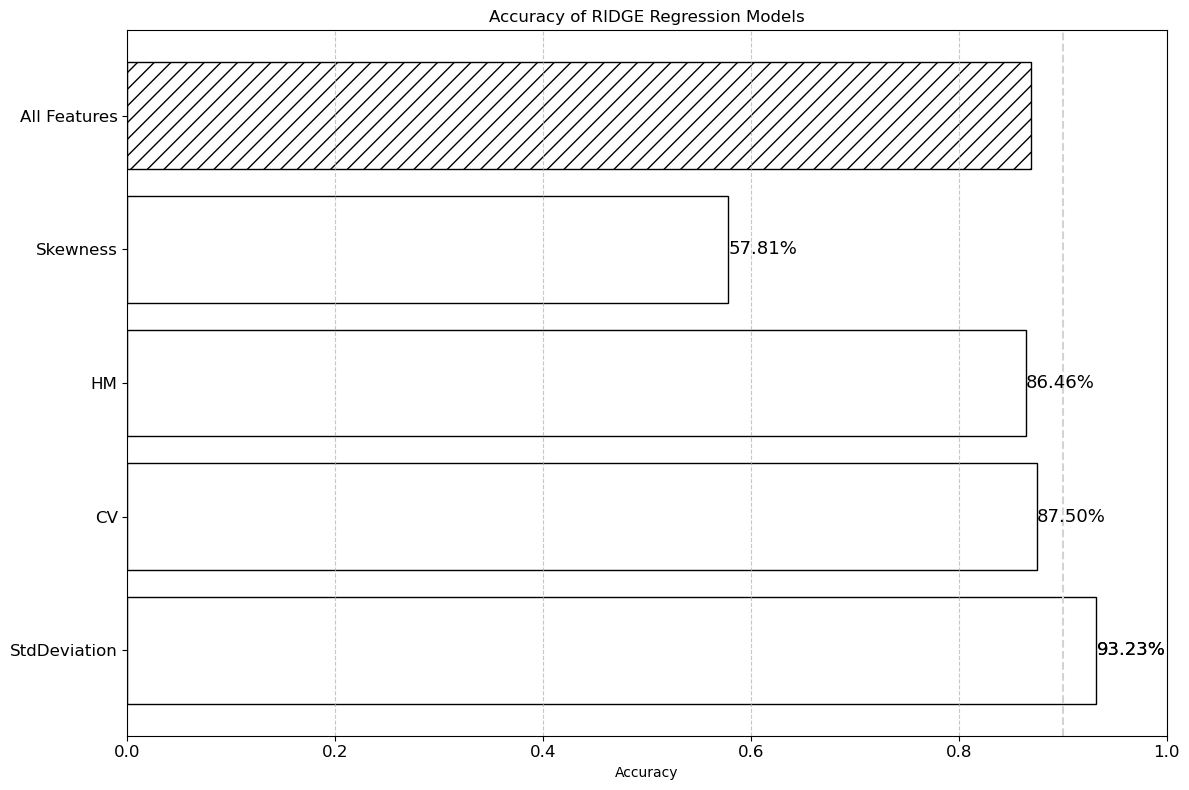

In [19]:
feature_names.append("All Features")
accuracies.append(comb_accuracy)

plt.figure(figsize=(12, 8))

bars_single = plt.barh(feature_names[:-1], accuracies[:-1], color='white', hatch='', edgecolor='black')
bar_all = plt.barh(feature_names[-1], accuracies[-1], color='white', hatch='//', edgecolor='black')

plt.xlabel('Accuracy')
plt.title('Accuracy of RIDGE Regression Models')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.axvline(x=0.9, color='lightgrey', linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for bar in bars_single:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()*100:.2f}%',
             va='center', ha='left', fontsize=13)

plt.text(accuracies[0], feature_names[0],
         s = f'{accuracies[0]*100:.2f}%',  # Multiply by 100 to show percentage
         va='center', ha='left', fontsize=13)


plt.tight_layout()
plt.show()

### Feature Selection

Feature selection refers to the ranking of the impact or contribution of each feature to the predictions made by the model. In Ridge regression, feature importance is often associated with the magnitude (absolute value) of the coefficients assigned to each feature. In Ridge regression, the regularization term (L2 norm) penalizes large coefficients. As a result, features with larger absolute coefficients tend to have higher importance because they contribute more to the overall predictions. The larger the absolute value of the coefficient assigned to a feature, the more influential that feature is in determining the model's predictions.

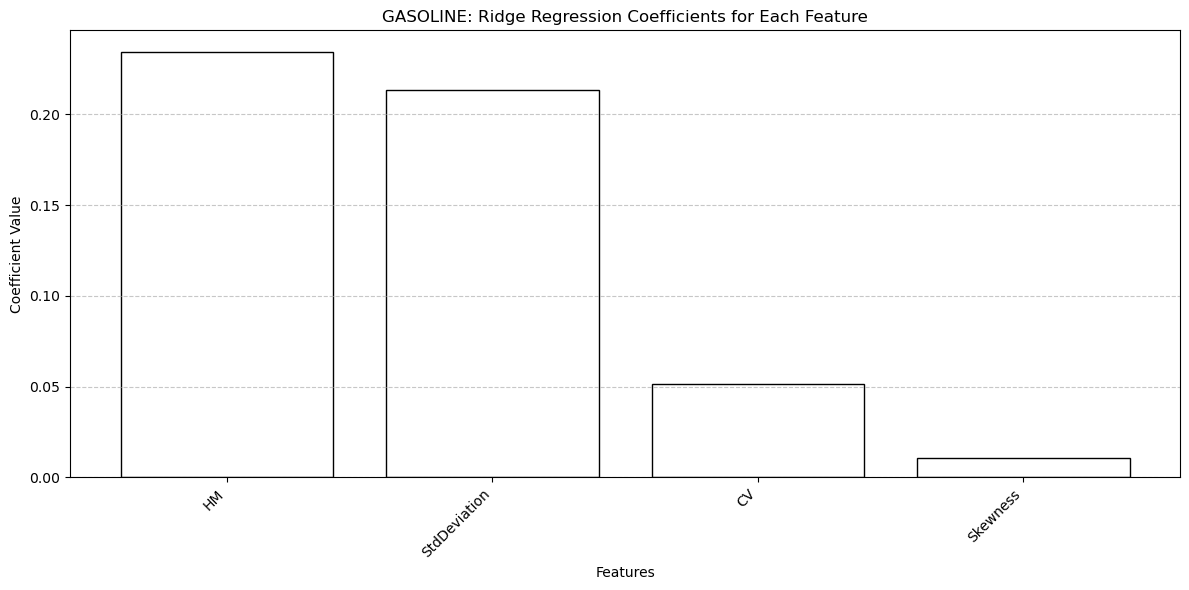

In [20]:
feature_coefficients = dict(zip(features, abs(ridge_model.coef_)))

sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_coeffs = zip(*sorted_coefficients)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_coeffs, edgecolor='black', hatch='', color='white')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('GASOLINE: Ridge Regression Coefficients for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('RDIGE_Feature_Selection_Gasoline.png')
plt.show()


Intersting to see how that, when using all features togheter, the High-Mean measure is given more importance (larger coefficient) than the Standard Deviation, which when used alone is the most accurate predictor. Also, becasue of how Ridge is structured Skewness remains relevant even if in a smaller share.

## LASSO

We proceed with similar steps with LASSO prediction models

In [21]:
# Re-Initialize a dictionary to store confusion matrices, accuracies and names
confusion_matrices = {}
feature_names = []
accuracies = []
coefficients_single = []
features_single = []
comb_accuracy = []
alpha_accuracies = []

### Alpha Optimization

With LASSO, again determines the weight of the penality associated with the prediction. However, in this case the penalty can lead to the complete elimination (shrinkage to zero) of irrelevant coefficient, thus alpha selection is more important as it will have a significant impact on feature selection.

We again use K-Fold Cross Validation.

In [22]:
k_folds = 10

lasso_model = Lasso()

# Perform stratified k-fold cross-validation
cv_stratified = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

alphas = [0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    lasso_model.alpha = alpha
    fold_accuracies = [] 
    for train_idx, test_idx in cv_stratified.split(X_train_scaled, y_train):
        X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        lasso_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = (lasso_model.predict(X_test_fold) > 0.5).astype(int)

        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
    
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    
    print(f"Alpha={alpha}: Mean Accuracy: {mean_accuracy}")

Alpha=0.01: Mean Accuracy: 0.8956083390293916
Alpha=0.1: Mean Accuracy: 0.8956083390293916
Alpha=1: Mean Accuracy: 0.6149008885850991
Alpha=10: Mean Accuracy: 0.6149008885850991
Alpha=100: Mean Accuracy: 0.6149008885850991


An alpha greater than 0.1 leads to large losses in accuracy. Thus we set alpha equal to 0.1

### Running the Model

Again, we first run it with all features and then we single out each features.

In [23]:
## ALL FEATURES

lasso_model = Lasso(alpha=0.1) 
lasso_model.fit(X_train_scaled, y_train)

y_pred_all = lasso_model.predict(X_test_scaled)

# Convert predictions to binary (0 or 1)
y_pred_all_binary = [1 if pred > 0.5 else 0 for pred in y_pred_all]

# Get coefficients
all_features_coefficients = np.abs(lasso_model.coef_)

# Calculate confusion matrix
cm_all = confusion_matrix(y_test, y_pred_all_binary)
confusion_matrices["AllFeatures"] = cm_all

comb_accuracy = accuracy_score(y_test, y_pred_all_binary)
accuracies.append(comb_accuracy)

feature_names.append("All Features")

In [24]:
## PER SIGLE FEATURE
# Train separate LASSO regression models 
for feature in features:
    X_single = df[[feature]]
    
    X_train_single, X_test_single, y_train, y_test_single = train_test_split(X_single, y, test_size=0.2, random_state=42)

    # Standardize single feature
    scaler_single = StandardScaler()
    X_train_single_scaled = scaler_single.fit_transform(X_train_single)
    X_test_single_scaled = scaler_single.transform(X_test_single)

    # Train
    lasso_model_single = Lasso(alpha=0.1)
    lasso_model_single.fit(X_train_single_scaled, y_train)

    y_pred_single = lasso_model_single.predict(X_test_single_scaled)

    # Convert predictions to binary (0 or 1)
    y_pred_single_binary = [1 if pred > 0.5 else 0 for pred in y_pred_single]

    # Calculate confusion matrix
    cm_single = confusion_matrix(y_test_single, y_pred_single_binary)
    confusion_matrices[feature] = cm_single
    
    # Append feature name and accuracy to lists
    feature_names.append(feature)
    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    accuracies.append(accuracy_single)
    
    # Get coefficient for this feature and store it
    coefficients_single.append(np.abs(lasso_model_single.coef_[0]))
    features_single.append(feature)

    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    print(f'Accuracy using {feature}: {round(accuracy_single*100,2)}%')
print(f'Accuracy using all features: {round(comb_accuracy*100, 2)}%')

Accuracy using StdDeviation: 96.88%
Accuracy using CV: 95.31%
Accuracy using HM: 86.46%
Accuracy using Skewness: 57.81%
Accuracy using all features: 86.98%


Accuracy results from LASSO prediction seem to be in line with the Ridge predictions. However, for the Coefficient of Variation, accuracy increased significantly to above 95%.

We not check the confusion matrix for each result.

In [25]:
# Print confusion matrices for each model
for feature, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {feature}:")
    print(cm)

Confusion Matrix for AllFeatures:
[[86 25]
 [ 0 81]]
Confusion Matrix for StdDeviation:
[[105   6]
 [  0  81]]
Confusion Matrix for CV:
[[102   9]
 [  0  81]]
Confusion Matrix for HM:
[[85 26]
 [ 0 81]]
Confusion Matrix for Skewness:
[[111   0]
 [ 81   0]]


Results remain the same, but for StdDeviation and CV, the cases of false-positive are more than halved, thus explaing the boost in accuracy.

### Graphing Accuracy

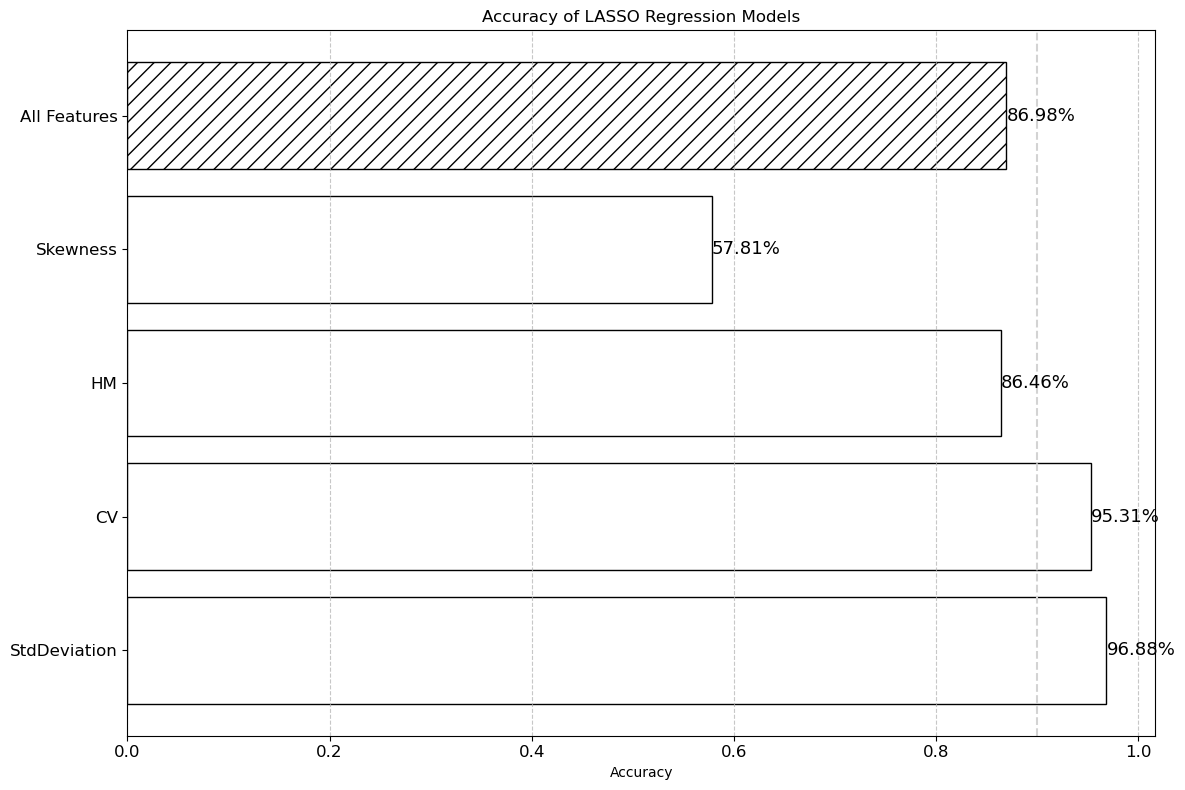

In [26]:
plt.figure(figsize=(12, 8))

bars_single = plt.barh(feature_names[1:], accuracies[1:], color='white', hatch='', edgecolor='black')
bar_all = plt.barh(feature_names[0], accuracies[0], color='white', hatch='//', edgecolor='black')

plt.xlabel('Accuracy')
plt.title('Accuracy of LASSO Regression Models')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.axvline(x=0.9, color='lightgrey', linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for bar in bars_single:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()*100:.2f}%',
             va='center', ha='left', fontsize=13)

plt.text(accuracies[0], feature_names[0],
         s = f'{accuracies[0]*100:.2f}%',  
         va='center', ha='left', fontsize=13)

plt.tight_layout()
plt.show()

### Feature Selection

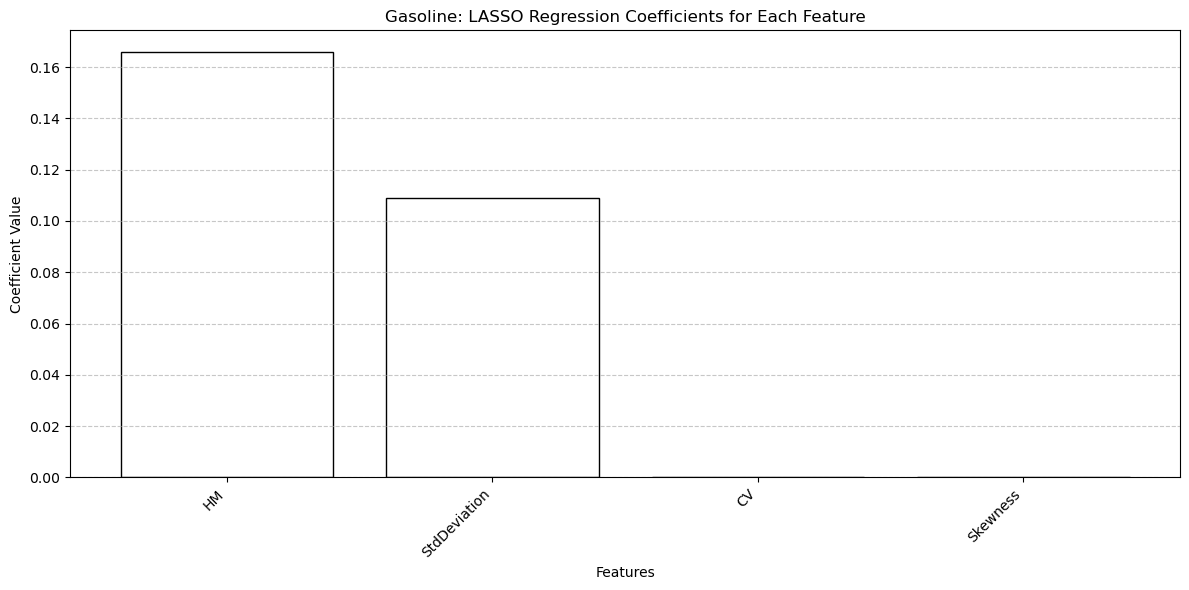

In [27]:
feature_coefficients = dict(zip(features, abs(lasso_model.coef_)))

sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_coeffs = zip(*sorted_coefficients)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_coeffs, edgecolor='black', hatch='', color='white')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Gasoline: LASSO Regression Coefficients for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('LASSO_Feature_Selection_Gasoline.png')
plt.show()


Here the results are a bit surprising. When using all features togheter the coefficient associated to the measure of Skewness is completly tropped to zero, which is intutive due to the lack of accuracy. However, the same is done for the CV measure, which we have seen before how accurate it is to predict collusion by itself. This is probably due to the high degre if collinearity between CV and StdDev.

I was interested to see if I could run the LASSO prediction again, while fixing the coeffcient value for CV to the level of the Ridge regression (~ 0.05), however after some research I believe this is not possible. 

## Neural Network

We know run the same analysis with the Neural Network algorithm, which however is structured in a different way thus does not have the same properties as LASSO and Ridge. For example it does not make sense to run it on the single feature separately. Neural Networks can learn complex patterns and relationships within the data, via complex non-linear transformations of each feature and for combinations of the feature, which would not happem by feeding it a single feature. 

### Neural Network Architecture

Here we define how the algorithm is structured. We start with the classical three layers. The first is the input layer, which feeds the data to the algorithm. It has 64 neurons with a ReLU activation function, used to handle non-linearity. The code `input_shape` specifies that the algorithm will work with four features.

The second is the hidden layer, which takes the input data and operates the transformation functions, again usinf ReLU activation and with 32 neurons.

The third and last layer is the output layer, which gives us the binary outcome between collusion or not. This last layer used a Sigmoid function (logistic function) to transorm the values into either 1 or 0

In [28]:
# Define the neural network architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train_scaled.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

The model compile is done with the Adam optimizer, one of the most popular method of compilation. The `binary_crossentropy` argument is the loss function that is able to deal with binary classification. The math behind this is out of the scope of my work (I hope). However, in my final document I will go over how a Neural Network algorithm is structured and how it works.

We now run the model over 50 epochs (naively repetitions), with a bach size of 32, meaning the set of sample selected in each repetition on which the algorithm is trained and updated.

In [29]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test);

Epoch 1/50
20/20 [==============================] - 1s 26ms/step - loss: 0.6736 - accuracy: 0.6013 - val_loss: 0.5042 - val_accuracy: 0.9221
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.4644 - accuracy: 0.8840 - val_loss: 0.3472 - val_accuracy: 0.9351
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 0.3486 - accuracy: 0.8938 - val_loss: 0.2545 - val_accuracy: 0.9416
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.2717 - accuracy: 0.9003 - val_loss: 0.2013 - val_accuracy: 0.9545
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 0.2179 - accuracy: 0.9199 - val_loss: 0.1680 - val_accuracy: 0.9610
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.1754 - accuracy: 0.9428 - val_loss: 0.1403 - val_accuracy: 0.9610
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.1425 - accuracy: 0.9739 - val_loss: 0.1211 - val_accuracy: 0.9675
Epoch 8/50
20/20 [=

In [30]:
print(f'Test Accuracy: {round(test_accuracy*100, 2)}%')

Test Accuracy: 97.92%


We see how the Neural Network, with its complexity is able to produce the most accurate predictions.

### Confusion Matrix

Here we produce the confusion matrix, similiarly as before

In [31]:
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

6/6 [==============================] - 0s 3ms/step
Confusion Matrix:
[[107   4]
 [  0  81]]


Again, no false negative. Overall we can say that in terms of pure accuracy Neural Networks, with a combination of all features is able to provde the best results.

### Diesel

The three algorithms so far have worked for the petrol product. I will now quickly run the analysis on the Diesel product which can serve as a sort of validation for the previous results.

In [32]:
# Load CSV into DataFrame
df = pd.read_csv(r"C:\Users\loren\Desktop\Thesis\Data\FinalData\final_diesel.csv")
df.dropna(inplace=True)

# Encode categorical variable
df = pd.get_dummies(df, columns=['Municipality'])

# Select features and target
features = ['StdDeviation', 'CV', 'HM', 'Skewness']
X = df[features]
y = df['isCollusion']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### RIDGE

In [33]:
# ALPHA
k_folds = 10 

ridge_model = Ridge() 
accuracies = []


cv_stratified = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)


alphas = [0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge_model.alpha = alpha
    fold_accuracies = []  
    for train_idx, test_idx in cv_stratified.split(X_train_scaled, y_train):
        X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        ridge_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = (ridge_model.predict(X_test_fold) > 0.5).astype(int)
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    accuracies.append(mean_accuracy)
    
    print(f"Alpha={alpha}: Mean Accuracy: {mean_accuracy}")

Alpha=0.01: Mean Accuracy: 0.8969070403280929
Alpha=0.1: Mean Accuracy: 0.8969070403280929
Alpha=1: Mean Accuracy: 0.8969070403280929
Alpha=10: Mean Accuracy: 0.8969070403280929
Alpha=100: Mean Accuracy: 0.8956083390293916


In [34]:
#INITIALIZATION
confusion_matrices = {}
feature_names = []
accuracies = []
coefficients_single = []
features_single = []

In [35]:
## ALL FEATURES COMBINED

ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_scaled, y_train)

y_pred_all = ridge_model.predict(X_test_scaled)

y_pred_all_binary = [1 if pred > 0.5 else 0 for pred in y_pred_all]


all_features_coefficients = np.abs(ridge_model.coef_[0])

cm_all = confusion_matrix(y_test, y_pred_all_binary)
confusion_matrices["AllFeatures"] = cm_all


comb_accuracy = accuracy_score(y_test, y_pred_all_binary)

In [36]:
## MODEL PER FEATURE

for feature in features:
    X_single = df[[feature]]
    X_train_single, X_test_single, y_train, y_test_single = train_test_split(X_single, y, test_size=0.2, random_state=42)

    scaler_single = StandardScaler()
    X_train_single_scaled = scaler_single.fit_transform(X_train_single)
    X_test_single_scaled = scaler_single.transform(X_test_single)

    ridge_model_single = Ridge(alpha=10)
    ridge_model_single.fit(X_train_single_scaled, y_train)

    y_pred_single = ridge_model_single.predict(X_test_single_scaled)

    y_pred_single_binary = [1 if pred > 0.5 else 0 for pred in y_pred_single]

    cm_single = confusion_matrix(y_test_single, y_pred_single_binary)
    confusion_matrices[feature] = cm_single
    
    feature_names.append(feature)
    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    accuracies.append(accuracy_single)
    
    coefficients_single.append(np.abs(ridge_model_single.coef_[0]))
    features_single.append(feature)

    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    print(f'Accuracy using {feature}: {round(accuracy_single*100,2)}%')
print(f'Accuracy using all features: {round(comb_accuracy*100, 2)}%')

Accuracy using StdDeviation: 92.19%
Accuracy using CV: 87.5%
Accuracy using HM: 86.46%
Accuracy using Skewness: 57.81%
Accuracy using all features: 86.98%


Similiar results as before. Slightly different numbers but same rage.

In [37]:
# CONFUSION MATRIX
for feature, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {feature}:")
    print(cm)

Confusion Matrix for AllFeatures:
[[86 25]
 [ 0 81]]
Confusion Matrix for StdDeviation:
[[96 15]
 [ 0 81]]
Confusion Matrix for CV:
[[87 24]
 [ 0 81]]
Confusion Matrix for HM:
[[85 26]
 [ 0 81]]
Confusion Matrix for Skewness:
[[111   0]
 [ 81   0]]


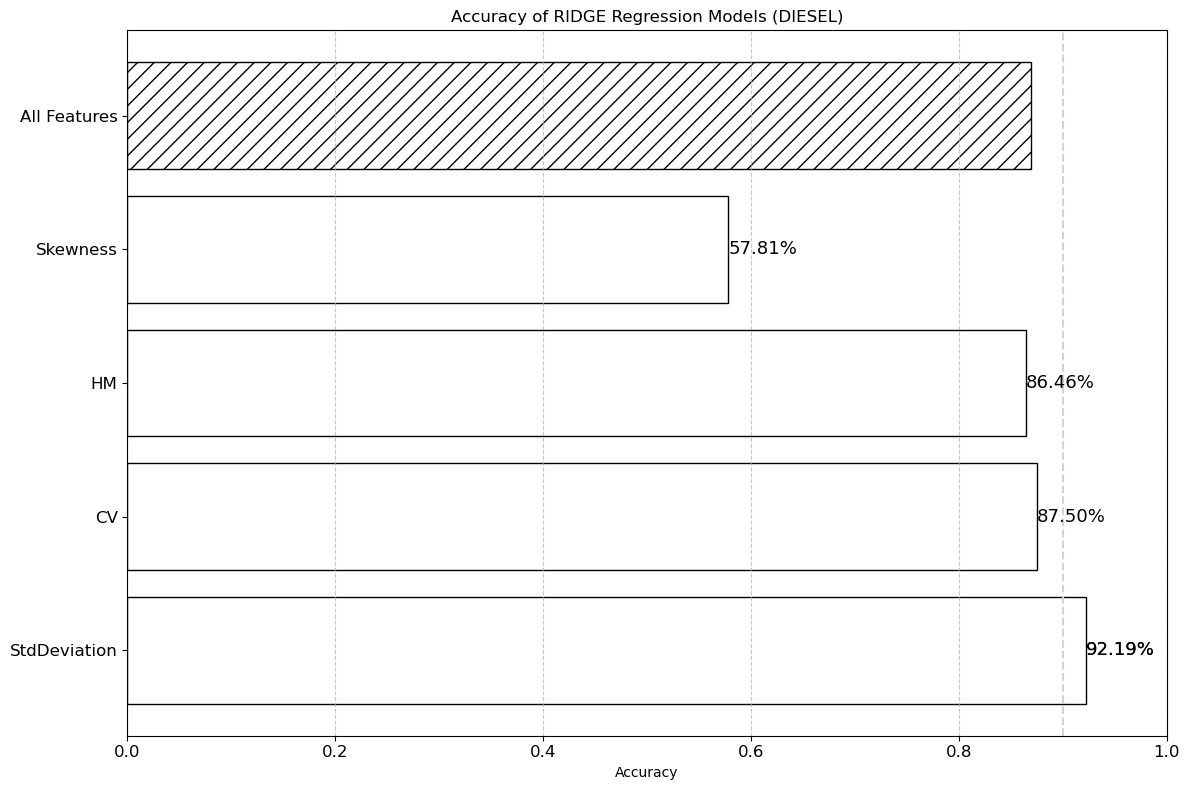

In [38]:
# ACCURACY VISUALIZATION
feature_names.append("All Features")
accuracies.append(comb_accuracy)

plt.figure(figsize=(12, 8))
bars_single = plt.barh(feature_names[:-1], accuracies[:-1], color='white', hatch='', edgecolor='black')
bar_all = plt.barh(feature_names[-1], accuracies[-1], color='white', hatch='//', edgecolor='black')
plt.xlabel('Accuracy')
plt.title('Accuracy of RIDGE Regression Models (DIESEL)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.axvline(x=0.9, color='lightgrey', linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for bar in bars_single:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()*100:.2f}%',
             va='center', ha='left', fontsize=13)

plt.text(accuracies[0], feature_names[0],
         s = f'{accuracies[0]*100:.2f}%',  # Multiply by 100 to show percentage
         va='center', ha='left', fontsize=13)


plt.tight_layout()
plt.show()

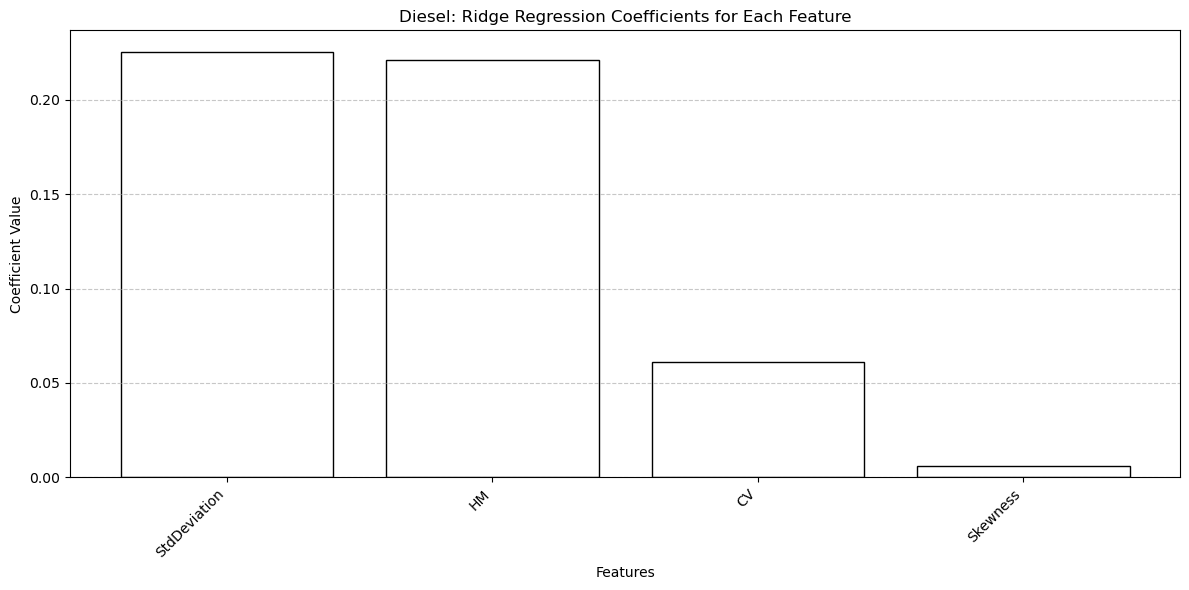

In [39]:
# FEATURE SELECTION
feature_coefficients = dict(zip(features, abs(ridge_model.coef_)))

sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

sorted_features, sorted_coeffs = zip(*sorted_coefficients)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_coeffs, edgecolor='black', hatch='', color='white')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Diesel: Ridge Regression Coefficients for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Ridge_Feature_Diesel.png')
plt.show()


### LASSO

In [40]:
# RE-INITIALIZATION
confusion_matrices = {}
feature_names = []
accuracies = []
coefficients_single = []
features_single = []
comb_accuracy = []
alpha_accuracies = []

In [41]:
# ALPHA
k_folds = 10

lasso_model = Lasso()

cv_stratified = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

alphas = [0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    lasso_model.alpha = alpha
    fold_accuracies = [] 
    for train_idx, test_idx in cv_stratified.split(X_train_scaled, y_train):
        X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        lasso_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = (lasso_model.predict(X_test_fold) > 0.5).astype(int)
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Alpha={alpha}: Mean Accuracy: {mean_accuracy}")

Alpha=0.01: Mean Accuracy: 0.8956083390293916
Alpha=0.1: Mean Accuracy: 0.8942754613807244
Alpha=1: Mean Accuracy: 0.6149008885850991
Alpha=10: Mean Accuracy: 0.6149008885850991
Alpha=100: Mean Accuracy: 0.6149008885850991


In [42]:
## ALL FEATURES COMBINED
lasso_model = Lasso(alpha=0.1) 
lasso_model.fit(X_train_scaled, y_train)

y_pred_all = lasso_model.predict(X_test_scaled)

y_pred_all_binary = [1 if pred > 0.5 else 0 for pred in y_pred_all]

all_features_coefficients = np.abs(lasso_model.coef_)


cm_all = confusion_matrix(y_test, y_pred_all_binary)
confusion_matrices["AllFeatures"] = cm_all

comb_accuracy = accuracy_score(y_test, y_pred_all_binary)
accuracies.append(comb_accuracy)

feature_names.append("All Features")

In [43]:
## PER SIGLE FEATURE

for feature in features:
    X_single = df[[feature]]
    X_train_single, X_test_single, y_train, y_test_single = train_test_split(X_single, y, test_size=0.2, random_state=42)
    scaler_single = StandardScaler()
    X_train_single_scaled = scaler_single.fit_transform(X_train_single)
    X_test_single_scaled = scaler_single.transform(X_test_single)

    lasso_model_single = Lasso(alpha=0.1)
    lasso_model_single.fit(X_train_single_scaled, y_train)

    y_pred_single = lasso_model_single.predict(X_test_single_scaled)
    y_pred_single_binary = [1 if pred > 0.5 else 0 for pred in y_pred_single]

    cm_single = confusion_matrix(y_test_single, y_pred_single_binary)
    confusion_matrices[feature] = cm_single
    
    feature_names.append(feature)
    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    accuracies.append(accuracy_single)
    
    coefficients_single.append(np.abs(lasso_model_single.coef_[0]))
    features_single.append(feature)
    
    accuracy_single = accuracy_score(y_test_single, y_pred_single_binary)
    print(f'Accuracy using {feature}: {round(accuracy_single*100,2)}%')
print(f'Accuracy using all features: {round(comb_accuracy*100, 2)}%')

Accuracy using StdDeviation: 97.4%
Accuracy using CV: 96.35%
Accuracy using HM: 85.42%
Accuracy using Skewness: 57.81%
Accuracy using all features: 86.98%


Similiar results as before, with the same increases in accuracy.

In [44]:
# CONFUSION MATRIX
for feature, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {feature}:")
    print(cm)

Confusion Matrix for AllFeatures:
[[86 25]
 [ 0 81]]
Confusion Matrix for StdDeviation:
[[106   5]
 [  0  81]]
Confusion Matrix for CV:
[[107   4]
 [  3  78]]
Confusion Matrix for HM:
[[86 25]
 [ 3 78]]
Confusion Matrix for Skewness:
[[111   0]
 [ 81   0]]


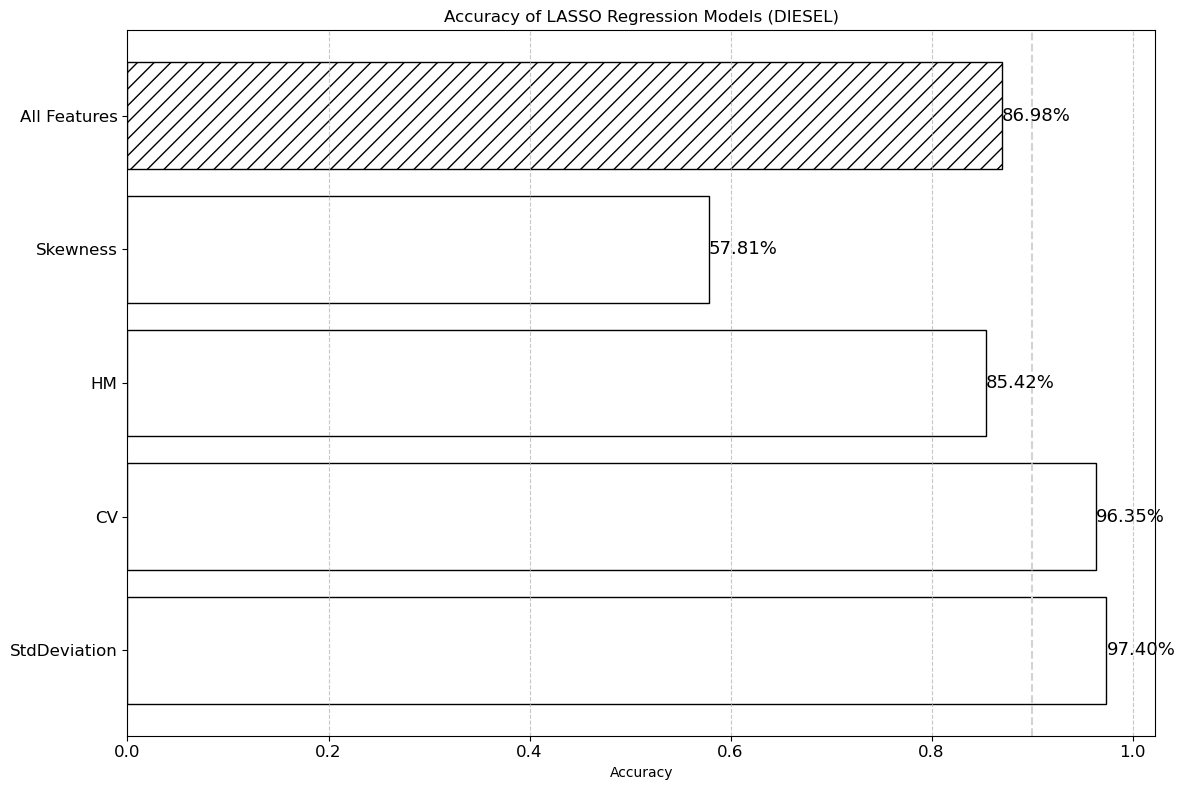

In [45]:
# ACCURACY VISUALIZATION
plt.figure(figsize=(12, 8))

bars_single = plt.barh(feature_names[1:], accuracies[1:], color='white', hatch='', edgecolor='black')
bar_all = plt.barh(feature_names[0], accuracies[0], color='white', hatch='//', edgecolor='black')

plt.xlabel('Accuracy')
plt.title('Accuracy of LASSO Regression Models (DIESEL)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.axvline(x=0.9, color='lightgrey', linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for bar in bars_single:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()*100:.2f}%',
             va='center', ha='left', fontsize=13)

plt.text(accuracies[0], feature_names[0],
         s = f'{accuracies[0]*100:.2f}%',
         va='center', ha='left', fontsize=13)

plt.tight_layout()
plt.show()

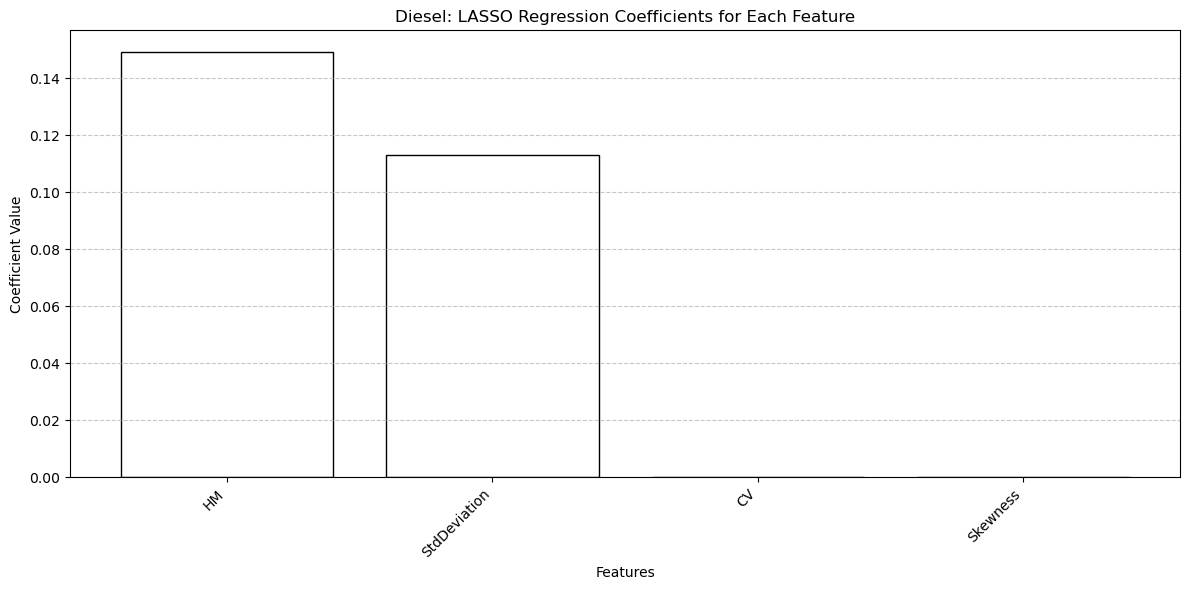

In [46]:
# FEATURE SELECTION
feature_coefficients = dict(zip(features, abs(lasso_model.coef_)))
sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

sorted_features, sorted_coeffs = zip(*sorted_coefficients)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_coeffs, edgecolor='black', hatch='', color='white')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Diesel: LASSO Regression Coefficients for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('LASSO_feature_diesel.jpg')
plt.show()

Again, similiar result of CV measure being dropped out.

### Neural Network

In [47]:
# NN ARCHITECTURE
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train_scaled.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# RUNNING THE MODEL
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test);

Epoch 1/50
20/20 [==============================] - 1s 19ms/step - loss: 0.5635 - accuracy: 0.8775 - val_loss: 0.4349 - val_accuracy: 0.9351
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 0.4199 - accuracy: 0.8905 - val_loss: 0.3187 - val_accuracy: 0.9351
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 0.3229 - accuracy: 0.8971 - val_loss: 0.2458 - val_accuracy: 0.9545
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.2608 - accuracy: 0.9216 - val_loss: 0.2038 - val_accuracy: 0.9610
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 0.2119 - accuracy: 0.9297 - val_loss: 0.1637 - val_accuracy: 0.9610
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.1729 - accuracy: 0.9444 - val_loss: 0.1379 - val_accuracy: 0.9675
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.1408 - accuracy: 0.9739 - val_loss: 0.1158 - val_accuracy: 0.9740
Epoch 8/50
20/20 [=

In [49]:
print(f'Test Accuracy: {round(test_accuracy*100, 2)}%')

Test Accuracy: 97.92%


Similiar accuracy results, above all other models

In [50]:
# CONFUSION MATRIX
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)

6/6 [==============================] - 0s 3ms/step
Confusion Matrix:
[[107   4]
 [  0  81]]
